# Shared libraries and packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
from sklearn.metrics import mean_squared_error

In [2]:
np.__version__

'1.26.4'

# "Final" Code

# Draft / Playground space below:

## Clayton Code

## Jackie Code

## Max Code

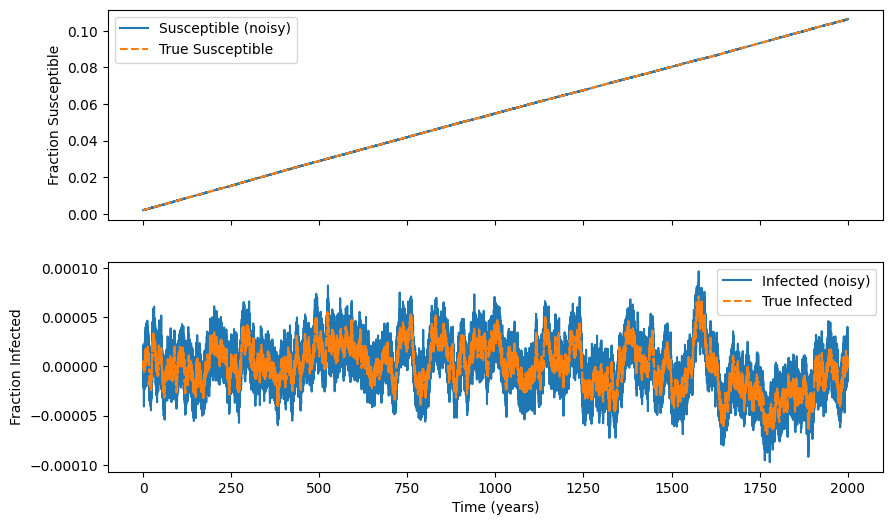

(S)[k+1] = 1.000 f0(S[k]) + 0.281 f0(I[k]) + -4.050 f1(S[k],I[k]) + -0.007 f1(S[k],beta[k]) + -18.358 f1(I[k],beta[k]) + 262.966 f2(S[k],I[k],beta[k])
(I)[k+1] = 0.672 f0(I[k]) + -1.207 f1(S[k],I[k]) + 0.010 f1(S[k],beta[k]) + 0.144 f1(I[k],beta[k]) + 216.072 f2(S[k],I[k],beta[k])
(beta)[k+1] = 0.221 f0(S[k]) + 101.444 f0(I[k]) + 1.000 f0(beta[k]) + -215.673 f1(S[k],I[k]) + -14.364 f1(S[k],beta[k]) + -6598.363 f1(I[k],beta[k]) + 14075.393 f2(S[k],I[k],beta[k])


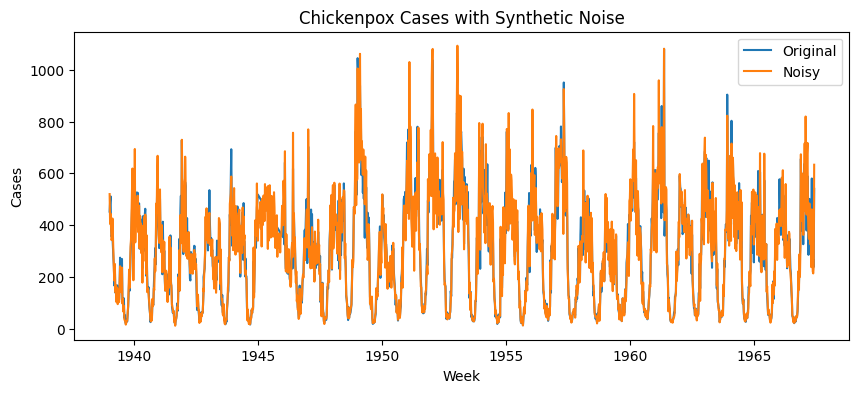

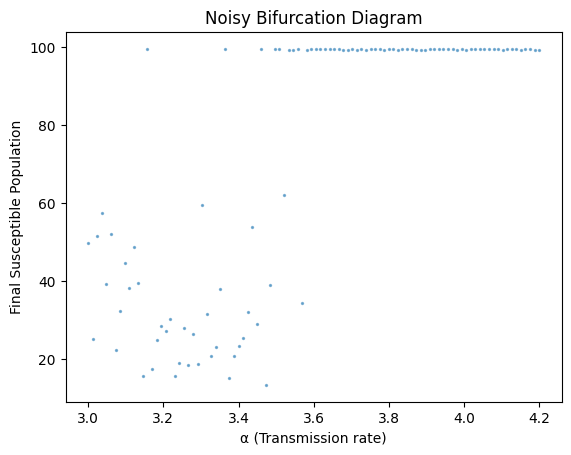

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.io import loadmat
import pandas as pd

##############################
# Synthetic SIR Model with Noise
##############################

# Simulation parameters
num_years = 2000
weeks_per_year = 52
total_weeks = num_years * weeks_per_year

# Noise parameters (adjust these to study noise effects)
process_noise_level = 1e-6  # Additive process noise amplitude
measurement_noise_level = 1e-5  # Measurement noise for observables
beta_noise_level = 0.01  # Multiplicative noise for transmission rate

# Initial conditions
S0 = 0.002
I0 = 0.0

# Model parameters
beta0 = 0.8 / weeks_per_year
beta1 = 0.025 / weeks_per_year
gamma = 0.1 / weeks_per_year
phi = 0.0
mu = 5.4795e-5 / weeks_per_year
nu = 5.4795e-5 / weeks_per_year

# Time array
t = np.linspace(0, num_years, total_weeks)

# Initialize arrays
beta = np.zeros_like(t)
S = np.zeros_like(t)
I = np.zeros_like(t)

# Set initial conditions
S[0] = S0
I[0] = I0

# Generate noise arrays
np.random.seed(0)
process_noise_S = process_noise_level * np.random.randn(total_weeks)
process_noise_I = process_noise_level * np.random.randn(total_weeks)
beta_noise = 1 + beta_noise_level * np.random.randn(total_weeks)

# Simulation loop
for week in range(total_weeks - 1):
    # Time-varying transmission rate with multiplicative noise
    beta[week] = beta0 * (1.0 + beta1 * np.cos(2*np.pi*week/weeks_per_year - phi)) * beta_noise[week]
    
    # Update equations with process noise
    S[week+1] = S[week] + nu - beta[week]*S[week]*I[week] - mu*S[week] + process_noise_S[week]
    I[week+1] = I[week] + beta[week]*S[week]*I[week] - gamma*I[week] - mu*I[week] + process_noise_I[week]

# Add measurement noise to observables
measurement_noise_S = measurement_noise_level * np.random.randn(total_weeks)
measurement_noise_I = measurement_noise_level * np.random.randn(total_weeks)
S_obs = S + measurement_noise_S
I_obs = I + measurement_noise_I

# Plot noisy system
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax1.plot(t, S_obs, label='Susceptible (noisy)')
ax1.plot(t, S, '--', label='True Susceptible')
ax1.set_ylabel('Fraction Susceptible')
ax1.legend()

ax2.plot(t, I_obs, label='Infected (noisy)')
ax2.plot(t, I, '--', label='True Infected')
ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Fraction Infected')
ax2.legend()
plt.show()

##############################
# SINDy Model Identification
##############################

# Create input matrix including transmission rate
X = np.vstack([S_obs, I_obs, beta]).T

# Custom library to capture SIR dynamics
library_functions = [
    lambda x: x,  # Identity
    lambda x,y: x*y,  # Interaction term
    lambda x,y,z: x*y*z  # Higher-order interaction
]

library_feature_names = [
    'S', 'I', 'beta',
    'S*I', 'S*beta', 'I*beta',
    'S*I*beta'
]

# Build custom library
custom_lib = ps.CustomLibrary(
    library_functions=library_functions,
)

# Robust differentiation method for noisy data
differentiation_method = ps.SmoothedFiniteDifference(
    smoother_kws={'window_length': 7},
    order=2
)

# Sparse regression with thresholding
optimizer = ps.STLSQ(threshold=1e-5, alpha=1e-3, normalize_columns=True)

# Create and fit SINDy model
model = ps.SINDy(
    feature_library=custom_lib,
    differentiation_method=differentiation_method,
    optimizer=optimizer,
    feature_names=['S', 'I', 'beta'],
    discrete_time=True
)

model.fit(X, t=t[1]-t[0])
model.print()

##############################
# Real Disease Data Analysis
##############################

# Load and preprocess real data
def load_disease_data(path):
    data = pd.read_csv(path, sep="\t", header=None)
    data.columns = ["week", "cases"]
    data["cases"] = data["cases"].interpolate()
    return data

# Add synthetic noise to real data
def add_measurement_noise(data, noise_level=0.1):
    noisy_data = data.copy()
    noise = noise_level * np.abs(data["cases"]) * np.random.randn(len(data))
    noisy_data["cases"] = data["cases"] + noise
    return noisy_data

# Analyze chickenpox data with added noise
chickenpox = load_disease_data('data/OntarioChickenWeekly39_69.txt')
chickenpox_noisy = add_measurement_noise(chickenpox, 0.15)

# Plot noisy real data
plt.figure(figsize=(10, 4))
plt.plot(chickenpox["week"], chickenpox["cases"], label='Original')
plt.plot(chickenpox_noisy["week"], chickenpox_noisy["cases"], label='Noisy')
plt.xlabel('Week')
plt.ylabel('Cases')
plt.title('Chickenpox Cases with Synthetic Noise')
plt.legend()
plt.show()

##############################
# Bifurcation Analysis with Noise
##############################

def noisy_bifurcation_analysis():
    alpha_vals = np.linspace(3, 4.2, 100)
    S_final = []
    
    for alpha in alpha_vals:
        S, I = 70., 30.
        for _ in range(1000):
            # Add noise to parameters
            noisy_beta = 0.8 + 0.1*np.random.randn()
            noisy_alpha = alpha + 0.05*np.random.randn()
            
            S_new = (1 - 0.005)*S - (noisy_alpha/100)*I*S + noisy_beta*(100 - S)
            I_new = (noisy_alpha/100)*I*S + (1 - noisy_beta - 0.1)*I
            
            S, I = max(0, S_new), max(0, I_new)
            
        S_final.append(S)
    
    plt.scatter(alpha_vals, S_final, s=2, alpha=0.5)
    plt.xlabel('α (Transmission rate)')
    plt.ylabel('Final Susceptible Population')
    plt.title('Noisy Bifurcation Diagram')
    plt.show()

noisy_bifurcation_analysis()

## Gaurav Code

In [72]:
!pip install numpy pandas scipy pysindy scikit-learn matplotlib requests

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached certifi-2025.4.26-py3-none-any.whl (159 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 3.6 MB/s eta 0:00:00a 0:00:01
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached urllib3-2.4.0-py3-none-any.whl (128 kB)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import odeint, solve_ivp
from scipy.signal import savgol_filter, detrend, welch, windows
from scipy.io import loadmat
from io import BytesIO
import requests

import pysindy as ps
from pysindy.optimizers import STLSQ
from sklearn.metrics import r2_score
from pysindy.feature_library import PolynomialLibrary

In [74]:
beta0, beta1 = 400.0, 200.0       # transmission baseline & seasonal amp
gamma       = 1/10.0             # recovery rate (1/week)
mu          = 1/(70*52.0)        # birth/death rate
N           = 1e6                # total population
phi         = 0.0                # seasonal phase
period      = 52                 # weeks per year
noise_amp   = 1e-5               # SIR noise level
seed        = 42                 # RNG seed

# time grid: 20 years of weekly points
t_sim = np.linspace(0, 20*period, 20*period + 1)
y0    = [0.99*N, 0.01*N, 0.0]     # initial [S, I, R]

In [75]:
!mkdir -p data

!wget -q https://raw.githubusercontent.com/jonathanhorrocks/SINDy-data/master/Horrocks_Repo/data/mDataFM_N.mat \
     -O data/mDataFM_N.mat

!wget -q https://raw.githubusercontent.com/jonathanhorrocks/SINDy-data/master/Horrocks_Repo/data/OntarioChickenWeekly39_69.txt \
     -O data/OntarioChickenWeekly39_69.txt

!wget -q https://raw.githubusercontent.com/jonathanhorrocks/SINDy-data/master/Horrocks_Repo/data/OntarioRubellaWeekly39_69.txt \
     -O data/OntarioRubellaWeekly39_69.txt

!ls -1 data

mDataEW_N.mat
mDataFM_N.mat
Ontario_Birth_Data_M.txt
OntarioChickenWeekly39_69.txt
Ontario_Demographics_Measles.txt
OntarioRubellaWeekly39_69.txt


In [80]:
measles = pd.DataFrame(
    loadmat('data/mDataEW_N.mat')['mDataN'],
    columns=['week','cases','population','births']
)

chickenpox = pd.read_csv(
    'data/OntarioChickenWeekly39_69.txt', sep='\t',
    header=None, names=['week','cases']
)
chickenpox['births']     = np.random.poisson(1500, len(chickenpox))
chickenpox['population'] = np.linspace(2e6,2.5e6,len(chickenpox))

rubella = pd.read_csv(
    'data/OntarioRubellaWeekly39_69.txt', sep='\t',
    header=None, names=['week','cases']
)
rubella['births']     = np.random.poisson(1200, len(rubella))
rubella['population'] = np.linspace(1.8e6,2.2e6,len(rubella))


def load_data(disease_name):
    """Loads the specified disease data."""
    if disease_name == 'measles':
        return measles
    elif disease_name == 'chickenpox':
        return chickenpox
    elif disease_name == 'rubella':
        return rubella
    else:
        raise ValueError(f"Unknown disease: {disease_name}")


print("Loaded:",
      len(measles),"measles rows;",
      len(chickenpox),"chickenpox rows;",
      len(rubella),"rubella rows")

Loaded: 991 measles rows; 1484 chickenpox rows; 1534 rubella rows


In [ ]:
def simulate_sir_seasonal(t, y0, beta0, alpha, gamma, mu, N, phi, period=52):
    def rhs(tt, y):
        S, I, R = y
        βt = beta0 * (1 + alpha * np.cos(2*np.pi*tt/period + phi))
        return [
            mu*(N - S)   - βt * S * I / N,
            βt * S * I / N - (gamma + mu) * I,
            gamma * I    - mu * R
        ]
    sol = solve_ivp(rhs, [t[0], t[-1]], y0, t_eval=t,
                    method='LSODA', rtol=1e-8, atol=1e-10)
    return sol.y  # shape (3,len(t))

def reconstruct_S_finkenstadt(cases, births, N_series, d_shift=5, window=52):
    C = np.cumsum(cases)
    B = np.cumsum(births)
    n = len(C)
    # shift births
    B_shift = np.empty(n)
    B_shift[:d_shift] = B[0]
    B_shift[d_shift:] = B[:-d_shift]
    # global fit (closed form)
    Cm, Bm = C.mean(), B_shift.mean()
    num = np.sum((C-Cm)*(B_shift-Bm))
    den = np.sum((C-Cm)**2)
    α, b0 = num/den, Bm - (num/den)*Cm
    # residual + rolling mean
    Z = B_shift - (α*C + b0)
    Zs = pd.Series(Z).rolling(window, center=True, min_periods=1).mean().values
    # reconstruct with dynamic N
    S_hat = N_series - C + Zs
    return np.clip(S_hat, 0, None)  # allow S ≤ N, but ≥ 0

def recover_beta(S, pre, t, gamma, mu, N, wI=15,oI=3,wB=31,oB=3):
    I_s = savgol_filter(pre, wI, oI)
    I_s = np.maximum(I_s,1e-6)
    dI  = np.gradient(I_s, t)
    denominator = S * I_s
    denominator[np.abs(denominator) < 1e-12] = 1e-12 # Use a small value to prevent inf/nan
    β   = (dI + (gamma+mu)*I_s)*N/denominator
    return savgol_filter(β, wB, oB)

def psd(ts, fs=1.0, taper=0.2):
    n = max(1,int(len(ts)*taper))
    window = windows.hann(n)
    f,P = welch(ts, fs=fs, nperseg=n, window=window)
    return f,P
power_spectral_density = psd


def run_sindy(X, t, dX=None, degree=2, threshold=1e-2):
    lib = ps.PolynomialLibrary(degree=degree)
    opt = STLSQ(threshold=threshold)
    model = ps.SINDy(feature_library=lib, optimizer=opt,
                     differentiation_method=None if dX is not None else 'finite_difference')
    if dX is None:
        model.fit(X, t=t)
    else:
        model.fit(X, t=t, x_dot=dX)
    return model

Points after crop: 1041 1041


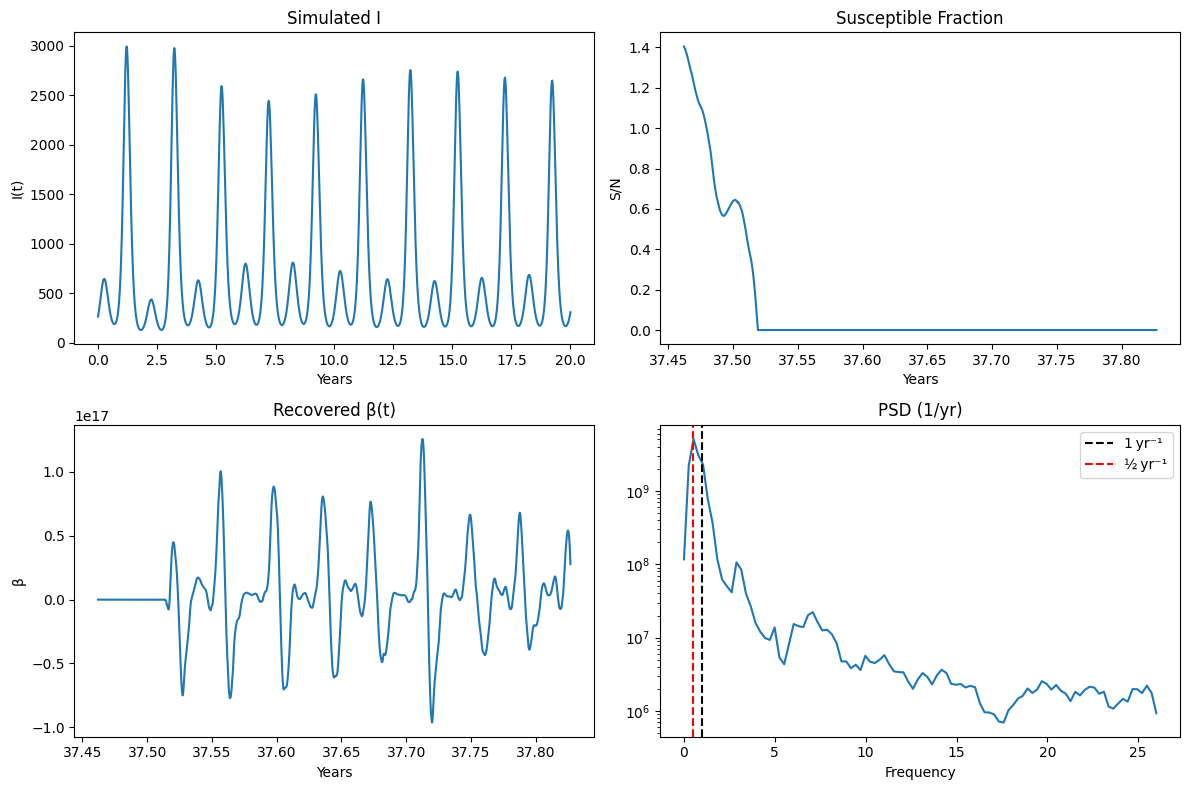

In [82]:
beta0, alpha = 400/52, 0.2
gamma, mu    = 0.5, 1/(50*52)
N            = 1e6
phi, period  = 0.0, 52

cases  = measles['cases'].values
births = measles['births'].values

t_long = np.linspace(0,40*period,40*period+1)
y0_eq   = [ (gamma+mu)/beta0 * N, 1.0, N - (gamma+mu)/beta0 * N - 1.0 ]
S_long,I_long,_ = simulate_sir_seasonal(
    t_long, y0_eq, beta0,alpha,gamma,mu,N,phi,period
)

spin   = int(20*period)
t_sim  = t_long[spin:] - t_long[spin]    # 0 → 20*52
years  = t_sim/52.0                     # in years
I_sim  = I_long[spin:]

print("Points after crop:", len(years), len(I_sim))

S_hat  = reconstruct_S_finkenstadt(cases, births, N)
s_frac = S_hat/N
weeks  = measles['week'].values
beta_t = recover_beta(S_hat, cases/N, weeks, gamma, mu, N)
f_wk,Pxx= psd(cases,fs=1.0,taper=0.2)
f_yr    = f_wk*52

fig,axs=plt.subplots(2,2,figsize=(12,8))

axs[0,0].plot(years, I_sim)
axs[0,0].set(title="Simulated I",xlabel="Years",ylabel="I(t)")

axs[0,1].plot(weeks/52.0, s_frac)
axs[0,1].set(title="Susceptible Fraction",xlabel="Years",ylabel="S/N")

axs[1,0].plot(weeks/52.0, beta_t)
axs[1,0].set(title="Recovered β(t)",xlabel="Years",ylabel="β")

axs[1,1].semilogy(f_yr,Pxx)
axs[1,1].axvline(1,ls='--',c='k',label='1 yr⁻¹')
axs[1,1].axvline(0.5,ls='--',c='r',label='½ yr⁻¹')
axs[1,1].set(title="PSD (1/yr)",xlabel="Frequency")
axs[1,1].legend()

plt.tight_layout()
plt.show()


----- MEASLES minimal S–I discovery -----
dS/dt = 0.0428·1 + -0.0573·S + -0.0000·I
dI/dt = -0.0001·1 + 0.0000·S


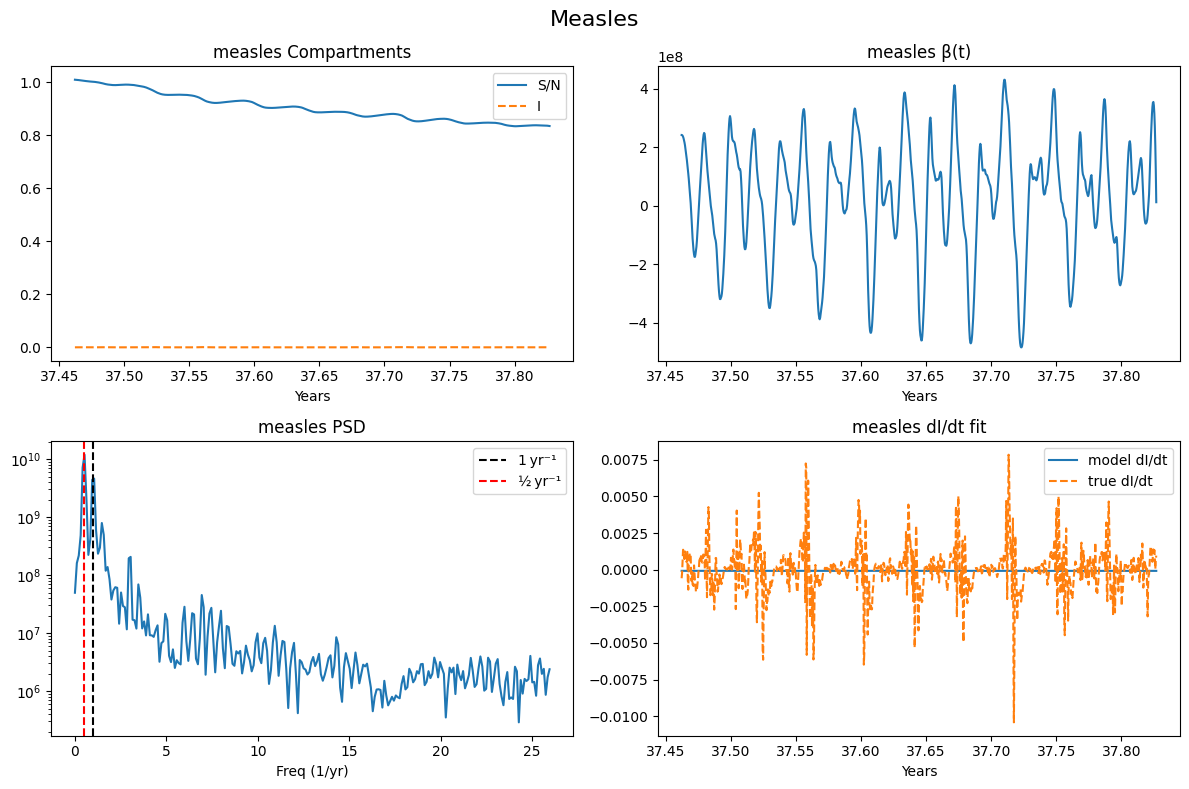


----- CHICKENPOX minimal S–I discovery -----
dS/dt = 
dI/dt = 


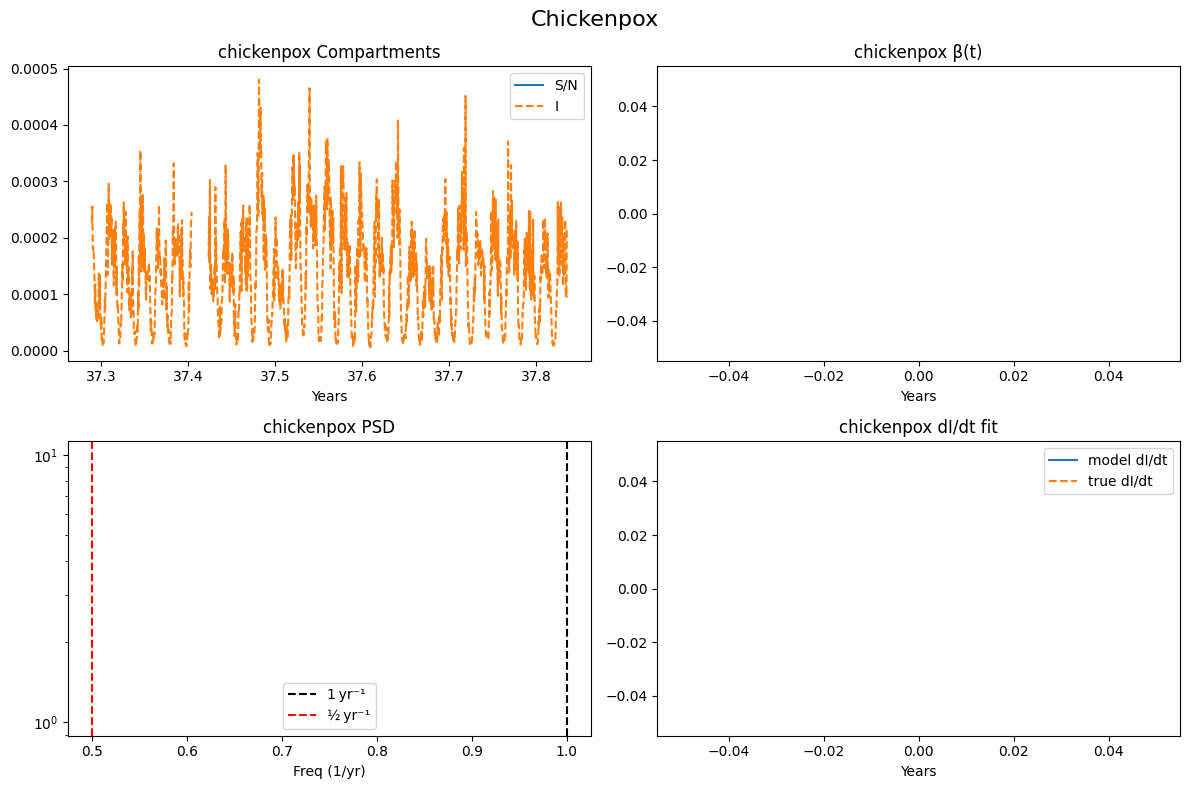


----- RUBELLA minimal S–I discovery -----
dS/dt = 
dI/dt = 


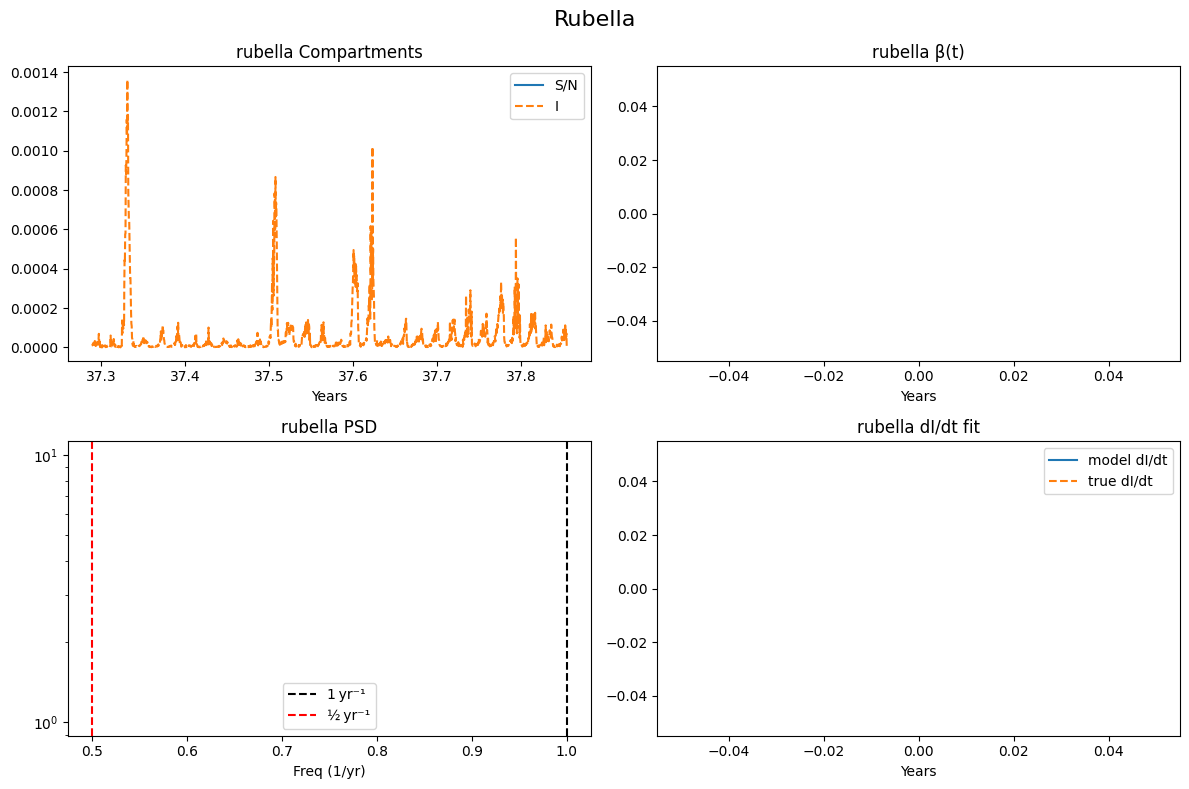

In [83]:
def analyze_disease_minimal(df, disease, threshold=1e-6, ridge_alpha=1e-6):

    t_wk = df.week.values
    t_yr = t_wk / 52.0
    cases     = df.cases.values
    births    = df.births.values
    N_series  = df.population.values
    gamma, mu = 0.5, 1/(50*52)

    # reconstruct & prevalence
    S_hat  = reconstruct_S_finkenstadt(cases, births, N_series)
    s_frac = S_hat / N_series
    I_pre  = cases / N_series

    # recover β(t)
    beta_t = recover_beta(s_frac, I_pre, t_wk, gamma, mu, N_series)

    # PSD
    f_wk, Pxx = welch(cases, fs=1, nperseg=min(1024, len(cases)//2))
    f_yr      = f_wk * 52

    # derivatives
    dS = np.gradient(s_frac, t_wk)
    dI = np.gradient(I_pre,  t_wk)

    # build minimal library Θ = [1, S, I, β·S·I]
    ones = np.ones_like(s_frac)
    Θ    = np.column_stack([ones, s_frac, I_pre, beta_t*s_frac*I_pre])
    names= ['1','S','I','βSI']

    # mask bad rows
    ok   = np.isfinite(Θ).all(1) & np.isfinite(dS) & np.isfinite(dI)
    Θm   = Θ[ok]
    dSm  = dS[ok]
    dIm  = dI[ok]

    # normal equations solve (4×4 invert)
    Dm = np.vstack([dSm, dIm]).T     # (m,2)
    M  = Θm.T @ Θm                   # (4,4)

    # Add ridge regularization to M to handle potential singularity
    M_reg = M + ridge_alpha * np.eye(M.shape[0])

    B  = Θm.T @ Dm                   # (4,2)

    Xi, residuals, rank, s = np.linalg.lstsq(M_reg, B, rcond=None)

    Xi[np.abs(Xi) < threshold] = 0.0

    print(f"\n----- {disease.upper()} minimal S–I discovery -----")
    for col, eqn in enumerate(['dS/dt','dI/dt']):
        terms = [f"{Xi[i,col]:.4f}·{names[i]}" for i in range(4) if Xi[i,col]!=0]
        print(f"{eqn} = " + " + ".join(terms))

    # plot
    fig, axs = plt.subplots(2,2,figsize=(12,8))
    axs[0,0].plot(t_yr, s_frac,   label='S/N')
    axs[0,0].plot(t_yr, I_pre, '--', label='I')
    axs[0,0].set(title=f"{disease} Compartments", xlabel="Years")
    axs[0,0].legend()

    axs[0,1].plot(t_yr, beta_t)
    axs[0,1].set(title=f"{disease} β(t)", xlabel="Years")

    axs[1,0].semilogy(f_yr, Pxx)
    axs[1,0].axvline(1,   ls='--', c='k', label='1 yr⁻¹')
    axs[1,0].axvline(0.5, ls='--', c='r', label='½ yr⁻¹')
    axs[1,0].set(title=f"{disease} PSD", xlabel="Freq (1/yr)")
    axs[1,0].legend()


    preds = Θm @ Xi[:,1]
    axs[1,1].plot(t_yr[ok], preds,     label='model dI/dt')
    axs[1,1].plot(t_yr[ok], dIm, '--', label='true dI/dt')
    axs[1,1].set(title=f"{disease} dI/dt fit", xlabel="Years")
    axs[1,1].legend()

    plt.suptitle(disease.capitalize(), fontsize=16)
    plt.tight_layout()
    plt.show()

    return Xi


models = {}
for name, df in zip(
    ['measles','chickenpox','rubella'],
    [measles, chickenpox, rubella]
):

    models[name] = analyze_disease_minimal(df, name, ridge_alpha=1e-6)

## Richard Code

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter, detrend, welch, windows

### Model Discovery from SIR Simulated Data

Explanation taken from "Model rediscovery from simulated data" [of original paper](https://www.nature.com/articles/s41598-020-63877-w#data-availability)
$$S_{t+1} = S_t + \nu - \beta (t) S_t I_t - \mu S_t,$$
$$I_{t+1} = I_t + \beta (t) S_t I_t - \gamma I_t - \mu I_t$$
$$R_{t+1} = R_t + \gamma I_t - \mu R_t$$

$S_t(I_t, R_t)$ is number of susceptible persons, $t$ is timestep, $\nu$ (resp. $\mu$) is the per capita birth (resp. death) rate per timestep, $\gamma$ is the per capita recovery rate per timestep, and $\beta(t)$ is the seasonally-varing transmission rate with form given by:

$$\beta(t) = \beta_0 (1 + \beta_1 \cos(2 \pi t/ T - \phi))$$ 

$T = 1$ year is period of oscillation, $\phi$ is a phase shift with seasonal behavior of the transmission rate. $t \approx$ one week for the paper

In [11]:
num_years = 2000
weeks_per_year = 52

# Initial conditions:
S_0 = 0.2
I_0 = 0
beta_0 = 0.8 / weeks_per_year
beta_1 = 0.025 / weeks_per_year
gamma = 0.2 / weeks_per_year          # per capita recovery rate
phi = np.pi * 0.                      # seasonal phase shift

mu = 5.4795*10e-5 / weeks_per_year # birth rate
nu = 5.4795*10e-5 / weeks_per_year # death rate

t = np.linspace(0, num_years, num_years * weeks_per_year)
beta = np.zeros(len(t))
S = np.zeros(len(t))
I = np.zeros(len(t))

np.random.seed(0)
noiseS = 10e-7 * np.random.randn(1,len(t)).squeeze()
noiseI = 10e-7 * np.random.randn(1,len(t)).squeeze()

S[0] = S_0
I[0] = I_0

for week in range(0,len(t)-1):
    beta[week] = beta_0 * (1.0 + beta_1 * np.cos(2.0*np.pi*float(week)/(1 / float(weeks_per_year)) - phi))
    S[week+1] = max(0, S[week] + nu - beta[week] * S[week] * I[week] - mu * S[week] + noiseS[week])
    I[week+1] = max(0, I[week] + beta[week] * S[week] * I[week] - gamma * I[week] - mu * I[week] + noiseI[week])

beta[len(t)-1] = beta_0 * (1.0 + beta_1 * np.cos(2.0*np.pi*float(t[-1])/ ( 1 / float(weeks_per_year)) - phi))

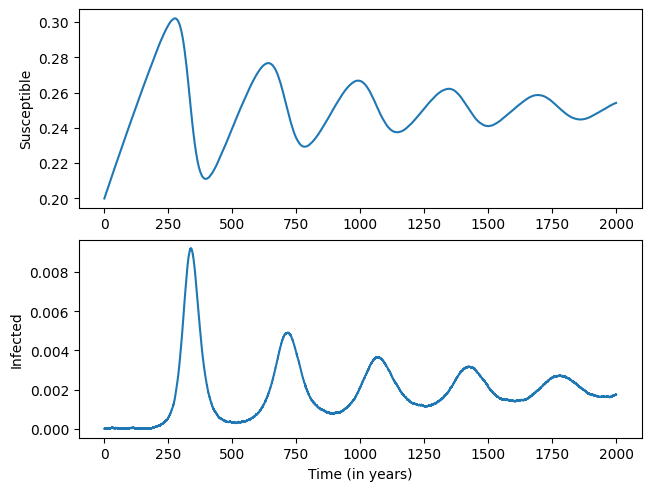

In [12]:
##############################
# Plot data
##############################

fig, ((ax1, ax2)) = plt.subplots(2, 1, layout="constrained")

ax1.plot(t,S)
ax1.set_ylabel('Susceptible')
ax1.set_title('')

ax2.plot(t,I)
ax2.set_xlabel('Time (in years)')
ax2.set_ylabel('Infected')
ax2.set_title('')
plt.show()

Helper function defined in [PySINDy lectures](https://github.com/dynamicslab/pysindy/blob/master/examples/15_pysindy_lectures.ipynb) for hyperparameter tuning:

In [13]:
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d

# Make coefficient plot for threshold scan
def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test, u):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, u=u, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0, :], len(t_test), u=u)
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)
    plt.figure()
    plt.semilogy(threshold_scan, mse, "bo")
    plt.semilogy(threshold_scan, mse, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.figure()
    plt.semilogy(threshold_scan, mse_sim, "bo")
    plt.semilogy(threshold_scan, mse_sim, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

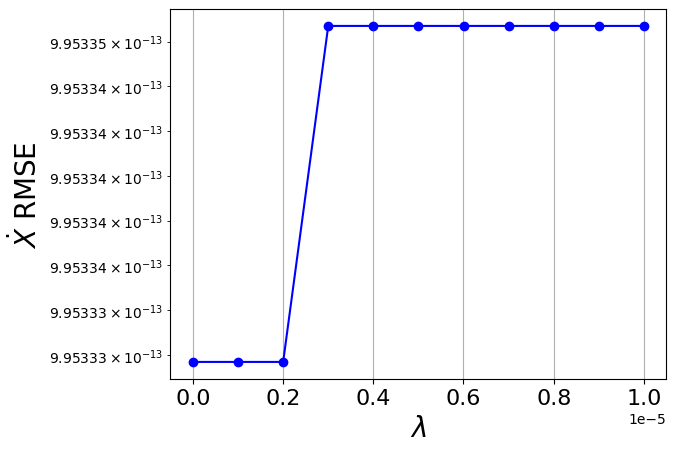

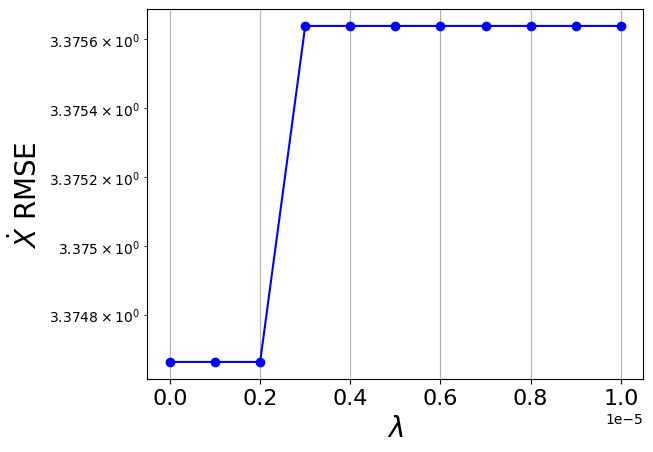

In [ ]:
threshold_scan = np.linspace(10e-10,10e-6,11)
coefs = []

poly_lib = ps.PolynomialLibrary(degree=3, interaction_only=False)

for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold, normalize_columns=True)
    model = ps.SINDy(feature_names=["S","I","beta"],
                     feature_library=poly_lib,
                     discrete_time=True,
                     optimizer=sparse_regression_optimizer)
    model.fit(x_data, t=t, u=beta, quiet=True)
    coefs.append(model.coefficients())
    
plot_pareto(coefs, sparse_regression_optimizer, model, 
            threshold_scan, x_data, t, beta)

Take $\lambda$ discovered via the hyperparameter tuning above ($\lambda \approx 10^{-10}$) and use that to construct a SINDy model

In [ ]:
##############################
# Construct SINDy model for SIR
##############################

# differentiation_method = ps.FiniteDifference(order=1)
poly_lib = ps.PolynomialLibrary(degree=3, interaction_only=False)
optimizer = ps.STLSQ(threshold=10e-10, normalize_columns=True)

x_data = np.transpose(np.array([S,I]))

sir_model = ps.SINDy(
    # differentiation_method=differentiation_method,
    feature_library=poly_lib,
    optimizer=optimizer,
    feature_names=["S","I","beta"],
    discrete_time=True
)

sir_model.fit(x_data, t=t, u=beta)
sir_model.print(precision=10)

(S)[k+1] = 0.0000079245 1 + 0.9997820631 S[k] + 0.0005296526 I[k] + 0.0000001220 beta[k] + -0.0001109914 S[k]^2 + -0.0193032893 S[k] I[k] + 0.0153886573 S[k] beta[k] + -0.0126652347 I[k]^2 + 0.0000081524 I[k] beta[k] + 0.0000000019 beta[k]^2 + 0.0001380333 S[k]^3 + 0.0074490707 S[k]^2 I[k] + -0.0000017084 S[k]^2 beta[k] + 0.0362442434 S[k] I[k]^2 + -0.0002971165 S[k] I[k] beta[k] + 0.0002368624 S[k] beta[k]^2 + 0.1729377022 I[k]^3 + -0.0001949434 I[k]^2 beta[k] + 0.0000001255 I[k] beta[k]^2
(I)[k+1] = -0.0000015175 1 + 0.0000196544 S[k] + 0.9958036650 I[k] + -0.0000000234 beta[k] + -0.0000823223 S[k]^2 + 0.0158916916 S[k] I[k] + 0.0000003025 S[k] beta[k] + 0.0090309881 I[k]^2 + 0.0153274218 I[k] beta[k] + -0.0000000004 beta[k]^2 + 0.0001130874 S[k]^3 + -0.0005838660 S[k]^2 I[k] + -0.0000012671 S[k]^2 beta[k] + -0.0237061584 S[k] I[k]^2 + 0.0002446051 S[k] I[k] beta[k] + 0.0000000047 S[k] beta[k]^2 + -0.1915738316 I[k]^3 + 0.0001390051 I[k]^2 beta[k] + 0.0002359199 I[k] beta[k]^2


In [16]:
##############################
# Simulate using SINDy model
##############################

init_value = x_data[0]
sim_sir = sir_model.simulate(init_value, t=len(t), u=beta)

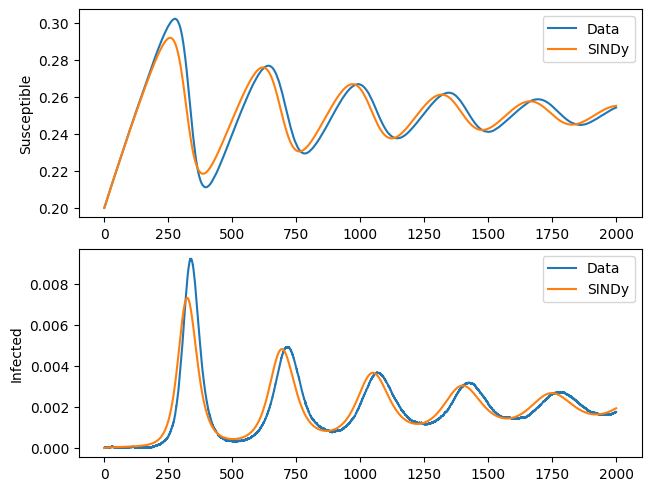

In [17]:
##############################
# Plot data
##############################

fig, ((ax1, ax2)) = plt.subplots(2, 1, layout="constrained")

ax1.plot(t, S, label="Data")
ax1.plot(t, sim_sir[:,0], label="SINDy")
ax1.set_ylabel('Susceptible')
ax1.legend()

ax2.plot(t, I, label="Data")
ax2.plot(t, sim_sir[:,1], label="SINDy")
ax2.set_ylabel('Infected')
ax2.legend()

plt.show()

##### **~~TODO: Do the same thing as above but with added noise~~ Done in slide_visuals.ipynb**

### Model Discovery from Empirical Data

##### Importing Data

In [13]:
##############################
# Load data
# ref: https://github.com/jonathanhorrocks/SINDy-data/tree/master/Horrocks_Repo/data
##############################

import pandas as pd

def load_dataset(disease):
    if disease.lower() == "rubella":
        rubella_data = pd.read_csv('data/OntarioRubellaWeekly39_69.txt', sep="\t", header=None)
        rubella_data.columns = ["week", "cases"]
        rubella_data = rubella_data[(rubella_data["week"] > 1946) & (rubella_data["week"] < 1961)].reset_index() # only take rubella between 1946 and 1961
        # Cleanup Rubella Data (remove NaN):
        # Scrub the NaN rows and create a new rubella_data_nonan set
        rubella_data_nonan = rubella_data.copy()
        rubella_data_nonan["cases"] = rubella_data["cases"].interpolate(method='linear', limit_direction='forward', axis=0)
        rubella_data = rubella_data_nonan

        return rubella_data


    elif disease.lower() == "chickenpox":
        chickenpox_data = pd.read_csv('data/OntarioChickenWeekly39_69.txt', sep="\t", header=None)
        chickenpox_data.columns = ["week", "cases"]
        chickenpox_data = chickenpox_data[(chickenpox_data["week"] > 1946) & (chickenpox_data["week"] < 1967)].reset_index() # only take chickenpox between 1946 and 1967

        return chickenpox_data

    elif disease.lower() == "measles":
        # Imports measles data matrix (stored as .mat file) - ref https://github.com/jonathanhorrocks/SINDy-data/blob/master/Horrocks_Repo/utils/susc_rec/SR_tester.m#L12C1-L13C54
        # Columns: | Time | Cases | Population | Births |
        import scipy.io
        measles_data = pd.DataFrame(scipy.io.loadmat('data/mDataEW_N.mat')["mDataN"])
        measles_data.columns = ["week", "cases", "population", "births"]
        measles_data = measles_data[(measles_data["week"] > 1948) & (measles_data["week"] < 1967)].reset_index() # only take measles data between 1948 and 1967

        return measles_data

    else:
        raise RuntimeError("Error: select one disease of (1) Rubella, (2) Chickenpox, or (3) Measles to load data")

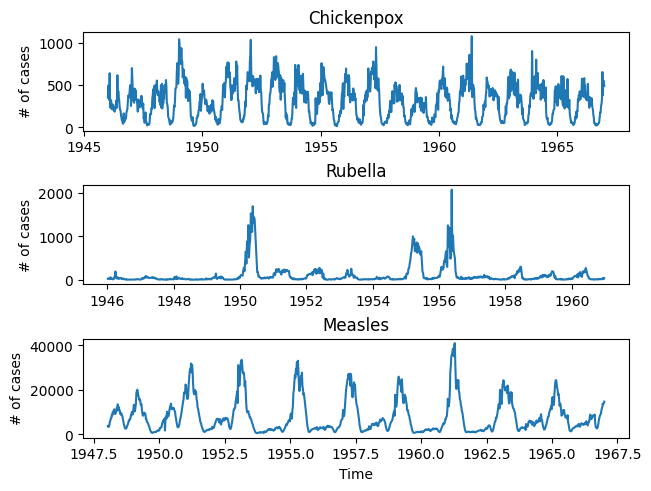

In [4]:
##############################
# Plot data
##############################

fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, layout="constrained")

chickenpox_data = load_dataset("chickenpox")
rubella_data = load_dataset("rubella")
measles_data = load_dataset("measles")

ax1.plot(chickenpox_data["week"],chickenpox_data["cases"])
ax1.set_ylabel('# of cases')
ax1.set_title('Chickenpox')

ax2.plot(rubella_data["week"],rubella_data["cases"])
ax2.set_ylabel('# of cases')
ax2.set_title('Rubella')

ax3.plot(measles_data["week"],measles_data["cases"])
ax3.set_xlabel('Time')
ax3.set_ylabel('# of cases')
ax3.set_title('Measles')

plt.show()

In [16]:
def get_population_and_birth_fit(disease="measles", plt_results=False):

    if disease.lower() == "rubella":

        rubella_data = load_dataset("rubella")

        # Load in demographic / birth rate data for Ontario (for Rubella)
        ontario_demographics = pd.read_csv('data/Ontario_Demographics_Measles.txt', sep="\t", header=None)
        ontario_demographics.columns = ["week", "pop"]

        ontario_birth_data = pd.read_csv('data/Ontario_Birth_Data_M.txt', sep="\t", header=None)
        ontario_birth_data.columns = ["week", "births"]

        # Linear interpolation to fill in missing week's data:
        ontario_population_growth_lin_fit = np.poly1d(np.polyfit(ontario_demographics["week"],ontario_demographics["pop"],1))
        P = ontario_population_growth_lin_fit(rubella_data["week"])

        ontario_birth_data_lin_fit = np.poly1d(np.polyfit(ontario_birth_data["week"],ontario_birth_data["births"],1))
        B = ontario_birth_data_lin_fit(rubella_data["week"])

        if plt_results:
            fig, ((ax1, ax2)) = plt.subplots(2, 1, layout="constrained")

            ax1.plot(rubella_data["week"], P, '--k', ontario_demographics["week"], ontario_demographics["pop"], 'yo')
            ax1.set_ylabel('Population')
            ax1.set_title('Linear Fit to Ontario Population Growth')

            ax2.plot(rubella_data["week"], B, '--k', ontario_birth_data["week"], ontario_birth_data["births"], 'yo')
            ax2.set_ylabel('Birth Rate')
            ax2.set_title('Linear Fit to Ontario Birth Rate')
            plt.show()
    
    elif disease.lower() == "chickenpox":

        chickenpox_data = load_dataset("chickenpox")

        # Load in demographic / birth rate data for Ontario (for Chickenpox)
        ontario_demographics = pd.read_csv('data/Ontario_Demographics_Measles.txt', sep="\t", header=None)
        ontario_demographics.columns = ["week", "pop"]

        ontario_birth_data = pd.read_csv('data/Ontario_Birth_Data_M.txt', sep="\t", header=None)
        ontario_birth_data.columns = ["week", "births"]

        # Linear interpolation to fill in missing week's data:
        ontario_population_growth_lin_fit = np.poly1d(np.polyfit(ontario_demographics["week"],ontario_demographics["pop"],1))
        P = ontario_population_growth_lin_fit(chickenpox_data["week"])

        ontario_birth_data_lin_fit = np.poly1d(np.polyfit(ontario_birth_data["week"],ontario_birth_data["births"],1))
        B = ontario_birth_data_lin_fit(chickenpox_data["week"])

        if plt_results:
            fig, ((ax1, ax2)) = plt.subplots(2, 1, layout="constrained")

            ax1.plot(chickenpox_data["week"], P, '--k', ontario_demographics["week"], ontario_demographics["pop"], 'yo')
            ax1.set_ylabel('Population')
            ax1.set_title('Linear Fit to Ontario Population Growth')

            ax2.plot(chickenpox_data["week"], B, '--k', ontario_birth_data["week"], ontario_birth_data["births"], 'yo')
            ax2.set_ylabel('Birth Rate')
            ax2.set_title('Linear Fit to Ontario Birth Rate')
            plt.show()

    elif disease.lower() == "measles":

        measles_data = load_dataset("measles")

        P = measles_data["population"]
        B = measles_data["births"]
        # subset_measles_data = measles_data[(measles_data["week"] > 1952) & (measles_data["week"] < 1967)].reset_index() # only take measles data where birth rate is linear (following Fig 38 of https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-020-63877-w/MediaObjects/41598_2020_63877_MOESM1_ESM.pdf)
        # EW_birth_data_lin_fit = np.poly1d(np.polyfit(subset_measles_data["week"],subset_measles_data["births"],1))
        # B = EW_birth_data_lin_fit(measles_data["week"])
        if plt_results:
            fig, ((ax1, ax2)) = plt.subplots(2, 1, layout="constrained")

            ax1.plot(measles_data["week"], P, '--k')
            ax1.set_ylabel('Population')
            ax1.set_title('England / Wales Population')

            ax2.plot(measles_data["week"], B, '--k')
            ax2.set_ylabel('Birth Rate')
            ax2.set_title('England / Wales Birth Rate')
            plt.show()
    
    else:
        raise RuntimeError("Error: select one disease of (1) Rubella, (2) Chickenpox, or (3) Measles to load data")
    
    return P, B

##### Susceptible Reconstruction

Generate "global" Susceptible Estimation:

$$Y_t = -Z_0 + \alpha X_t + R_t + Z_t - U_t$$

In [6]:
####
# Generate _global_ "Susceptible" Estimation for Disease Data
####

def SuscRec_FGglobal(C, B):
    # Input Cases and Birth rate
    # Returns the weighted difference from susceptible mean
    # (Zt-Z0) and the estimated under-reporting rate
    
    Y = np.cumsum(B)
    X = np.cumsum(C)
    P = np.polyfit(X,Y,1)

    alpha = P[1]
    Zt = Y[len(Y)-1] -  alpha*X[len(X)-1]
    return alpha, Zt

In [7]:
####
# Perform Global Susceptible estimation for Disease
####

def generate_global_susceptible(disease = "rubella", plt_results=False):
    if disease.lower() == "rubella":
        dataset = load_dataset("rubella")
        P, B = get_population_and_birth_fit("rubella")

    elif disease.lower() == "chickenpox":
        dataset = load_dataset("chickenpox")
        P, B = get_population_and_birth_fit("chickenpox")

    elif disease.lower() == "measles":
        dataset = load_dataset("measles")
        P, B = get_population_and_birth_fit("measles")

    else:
        raise RuntimeError("Error: select one disease of (1) Rubella, (2) Chickenpox, or (3) Measles to load data")
    
    S0_p = 0.1  # TODO : Replace this with a value for each disease,
                # corresponding to learned initial value that minimizes model AIC

    cases = dataset["cases"]
    week = dataset["week"]
    N = len(dataset["week"])
    S0 = S0_p * P[0]

    S = np.zeros(N)
    Z = np.zeros(N)
    alpha = np.zeros(N)

    for i in range(1,N):
        Z[i], alpha[i] = SuscRec_FGglobal(cases[:i], B[:i])
        S[i] = S0 + Z[i]

    global_susceptible = np.divide(S, P)
    if plt_results:
        fig, ((ax1)) = plt.subplots(1, 1, layout="constrained")

        ax1.plot(week, global_susceptible)
        ax1.set_ylabel('Susceptible Class (prop.)')
        ax1.set_title('Global ' + disease.capitalize() + ' Susceptible Reconstruction')

        plt.show()

    return global_susceptible

From `Susceptible Reconstruction` section of the [paper](https://www.nature.com/articles/s41598-020-63877-w.pdf):
$$Y_{t+1} = R_t - U_t Z_0 - (\alpha_{t+1} - \overline{\alpha} ) X_t + \alpha_{t+1} X_{t+1} + Z_{t+1} - u_{t+1}$$

where:
* $Y_t = \displaystyle{\sum_{i=1}^t B_{i-d,i-d+1}}$,
* $R_t = \displaystyle{\sum_{i=1}^t (\alpha_i - \overline{\alpha}) C_i}$,
* $U_t = \displaystyle{\sum_{i=1}^t u_i}$,
* $X_t = \displaystyle{\sum_{i=1}^t C_{i,i+1}}$,
* $B_{t,t+1}$ are the number of new births in week $t$
* $C_{t,t+1}$ are the number of new cases in week $t$
* $Z_t$ is the deviation from the mean Susceptible cases at week $t$, i.e. $S_t = \overline{S} + Z_t$,
* $\alpha_t$ is the rate at which cases are reported at week $t$,
* $u_t$ is the additive noise at week $t$ (assumed to be random Normal - $E(u) = 0, V(u) = \sigma_u^2$)

Code for generating Susceptible data in original paper (in MATLAB) can be found in [this folder](https://github.com/jonathanhorrocks/SINDy-data/tree/master/Horrocks_Repo/utils/susc_rec)


In [ ]:
####
# Some helper functions for Gaussian Kernels (used in SuscRec_FGlocal below)
# NOTE / WARNING: This is mostly just a guess at what this is doing; this 
# function isn't actually defined anywhere in the original source code
####

def gauss_kernel(u):
    return np.exp(-0.5 * u ** 2) # / np.sqrt(2 * np.pi)

def gaussKE(h, X, Y):
    N = len(X)
    rHat = np.zeros(N)
    for i in range(N):
        weights = gauss_kernel((X[i] - X) / h)
        weights_sum = np.sum(weights)
        rHat[i] = np.sum(weights * Y) / weights_sum if weights_sum != 0 else 0
    return rHat

####
# Helper Function to Generate _local_ "Susceptible" Estimation 
# See https://github.com/jonathanhorrocks/SINDy-data/blob/master/Horrocks_Repo/utils/susc_rec/SuscRec_FGlocal.m
####

def SuscRec_FGlocal(C, B, fac):
    # Returns the weighted difference from susceptible mean
    # (Zt-Z0) and the estimated under-reporting rate

    Y = np.cumsum(B)
    X = np.cumsum(C)
    rHat = gaussKE(fac * np.std(X), X ,Y)

    alpha = rHat[-1] / X[len(X)-1]
    Zt = Y[len(Y)-1] -  rHat[-1]
    return (Zt, alpha)


In [272]:
####
# Perform Local Susceptible estimation for Disease
####

def generate_local_susceptible(disease = "rubella", plt_results=False):
    if disease.lower() == "rubella":
        dataset = load_dataset("rubella")
        P, B = get_population_and_birth_fit("rubella")
        B_norm = B / (52. / 4.)
        # f is the Gaussian kernal's bandwidth parameter
        # this should be chosen to be the value where the SSE 
        # of both the local and global Susceptible estimations intersect
        f = 0.3

    elif disease.lower() == "chickenpox":
        dataset = load_dataset("chickenpox")
        P, B = get_population_and_birth_fit("chickenpox")
        B_norm = B / (52. / 4.)
        f = 0.2

    elif disease.lower() == "measles":
        dataset = load_dataset("measles")
        P, B = get_population_and_birth_fit("measles")
        B_norm = B
        f = 0.1

    else:
        raise RuntimeError("Error: select one disease of (1) Rubella, (2) Chickenpox, or (3) Measles to load data")
    
    S0_p = 0.1

    cases = dataset["cases"]
    week = dataset["week"]
    N = len(week)
    S0 = S0_p * P[0]
    
    S = np.zeros(N)
    Z = np.zeros(N)
    alpha = np.zeros(N)

    S[0] = S0
    alpha[0] = 8.
    Z[0] = 0.

    for i in range(1,N):
        Z[i], alpha[i] = SuscRec_FGlocal(cases[:i], B_norm[:i], f)
        S[i] = S0 + Z[i]

    local_susceptible = np.divide(S, P)
    local_susceptible = savgol_filter(local_susceptible, 5, 2) # smooth Susceptible data, see https://github.com/jonathanhorrocks/SINDy-data/blob/99e927c59f44ca100ffcb15d21c9b0275289025a/Horrocks_Repo/utils/dataSweepSetup.m#L184

    if plt_results:
        fig, ((ax1)) = plt.subplots(1, 1, layout="constrained")

        ax1.plot(week, local_susceptible)
        ax1.set_ylabel('Susceptible Class (prop.)')
        ax1.set_title('Local ' + disease.capitalize() + ' Susceptible Reconstruction')

        plt.show()

    return (alpha, local_susceptible, Z)

In the original paper, the Susceptible Reconstruction can be found in Figure 40 of [this appendix](https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-020-63877-w/MediaObjects/41598_2020_63877_MOESM1_ESM.pdf) (40a is Measles) - the plot above doesn't quite match, may need to figure out why

#### Incidence to prevalence conversion

Reconstruct the prevalence (infectious) class given incidence data using the conversion:
$$P_t = \frac{C_t p D_i}{\langle C_t \rangle L}$$
where $C_i$ is the temporal case incidence data $D_i = 2$ weeks for all $i$, $L = 65$ years, and $p = 0.95$

In [95]:
###
# Incidence to prevalence conversion
###

def get_incidence_reconstruction(disease = "rubella", plt_results=False):
    if disease.lower() == "rubella":
        dataset = load_dataset("rubella")
    elif disease.lower() == "chickenpox":
        dataset = load_dataset("chickenpox")
    elif disease.lower() == "measles":
        dataset = load_dataset("measles")
    else:
        raise RuntimeError("Error: select one disease of (1) Rubella, (2) Chickenpox, or (3) Measles to load data")
    
    weeks_per_year = 52
    D = 2                   # in weeks
    L = 65 * weeks_per_year # 65 years
    p = 0.95

    C = dataset["cases"].values
    P = C * p * D / (np.mean(C) * L)
    P = savgol_filter(P, 19, 3) # smooth Infectious Rate data, see https://github.com/jonathanhorrocks/SINDy-data/blob/99e927c59f44ca100ffcb15d21c9b0275289025a/Horrocks_Repo/utils/dataSweepSetup.m#L185

    if plt_results:
        fig, ((ax1)) = plt.subplots(1, 1, layout="constrained")

        ax1.plot(dataset["week"], P)
        ax1.set_ylabel('Infectious Class (prop.)')
        ax1.set_title('Local ' + disease.capitalize() + ' Infectious Reconstruction')

        plt.show()
    
    return P

#### Transmission rate reconstruction

This appears in Figure 41 in the Appendix [here](https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-020-63877-w/MediaObjects/41598_2020_63877_MOESM1_ESM.pdf)

Use:
$$\beta(t) = \frac{Z_{k+1}}{S_k I_k \Delta t} $$



In [274]:
def transmission_rate_reconstruction(disease = "rubella", plt_results=False):

    if disease.lower() == "rubella":
        dataset = load_dataset("rubella")
        alpha, susceptible, Z = generate_local_susceptible("rubella", False)
        infectious = get_incidence_reconstruction("rubella", False)

    elif disease.lower() == "chickenpox":
        dataset = load_dataset("chickenpox")
        alpha, susceptible, Z = generate_local_susceptible("chickenpox", False)
        infectious = get_incidence_reconstruction("chickenpox", False)

    elif disease.lower() == "measles":
        dataset = load_dataset("measles")
        alpha, susceptible, Z = generate_local_susceptible("measles", False)
        infectious = get_incidence_reconstruction("measles", False)

    else:
        raise RuntimeError("Error: select one disease of (1) Rubella, (2) Chickenpox, or (3) Measles to load data")
    
    N = len(dataset["week"])
    dt = 1 / N
    beta = np.zeros(N)

    for i in range(0,N-1):
        beta[i] = Z[i+1] / (susceptible[i] * infectious[i] * float(dt))
    # for i in range(0,N):
    #     beta[i] = alpha[i] * dataset["cases"].values[i] / (susceptible[i] * infectious[i])

    if plt_results:

        # fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, layout="constrained")
        fig, ((ax1, ax2)) = plt.subplots(2, 1, layout="constrained")

        ax1.plot(dataset["week"], susceptible)
        ax1.set_ylabel('S Class (prop)')
        ax1.set_title('Local ' + disease.capitalize() + ' Susceptible Reconstruction')
        ax2.plot(dataset["week"], infectious)
        ax2.set_ylabel('I Class (prop.)')
        ax2.set_title(disease.capitalize() + ' Infectious Reconstruction')
        # ax3.plot(dataset["week"], beta)
        # ax3.set_ylabel('Transmission')
        # ax3.set_title(disease.capitalize() + ' Transmission Rate Reconstruction')

        plt.show()

    return susceptible, infectious, beta

In [113]:
def get_calendar_from_transmission(beta, num_years):
    weeks_per_year = 52
    calendar = np.zeros((weeks_per_year, weeks_per_year * num_years))
    year_index = 0
    for i in range(0, len(beta)):
        calendar[i % weeks_per_year][year_index] = beta[i]
        if (i % weeks_per_year == 0):
            year_index += 1    
    return (np.mean(calendar, axis=1), np.std(calendar, axis=1))

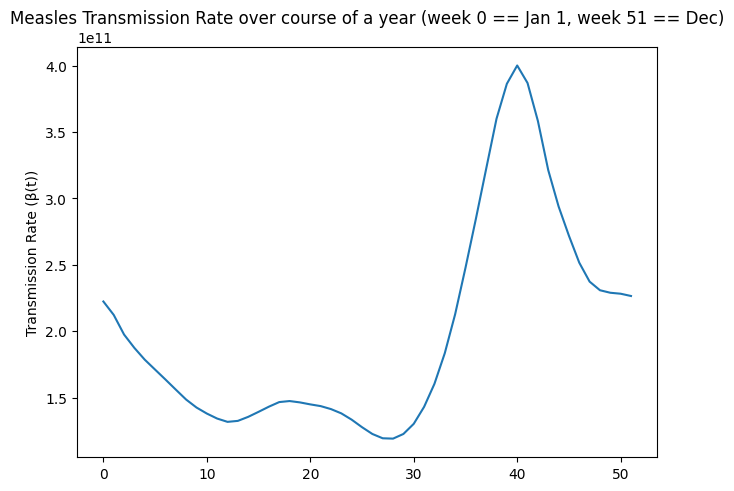

In [191]:
####
# Plot "Transmission Rate" Estimation for Measles Data
####

dataset = load_dataset("measles")
num_years = int(dataset["week"].values[-1]) - int(dataset["week"].values[0])
transmission_avg, transmission_std = get_calendar_from_transmission(beta, num_years)

fig, ((ax1)) = plt.subplots(1, 1, layout="constrained")

ax1.errorbar(np.arange(0,52), transmission_avg)
ax1.set_ylabel('Transmission Rate (β(t))')
ax1.set_title('Measles Transmission Rate over course of a year (week 0 == Jan 1, week 51 == Dec)')

plt.show()

#### Generate SINDy Model

In [309]:
def build_sindy(susceptible, infectious, beta, t, degree=2, threshold=10e-4):
    disease_si = np.transpose(np.array([susceptible, infectious]))
    init_value = np.transpose(np.array([susceptible[0], infectious[0]]))

    feature_library = ps.PolynomialLibrary(degree=degree)
    optimizer = ps.STLSQ(threshold=threshold)

    disease_model = ps.SINDy(
        feature_library=feature_library,
        optimizer=optimizer,
        feature_names=["S","I","beta"],
        discrete_time=True
    )

    disease_model.fit(disease_si, t=t, u=beta)
    return (disease_model, init_value)

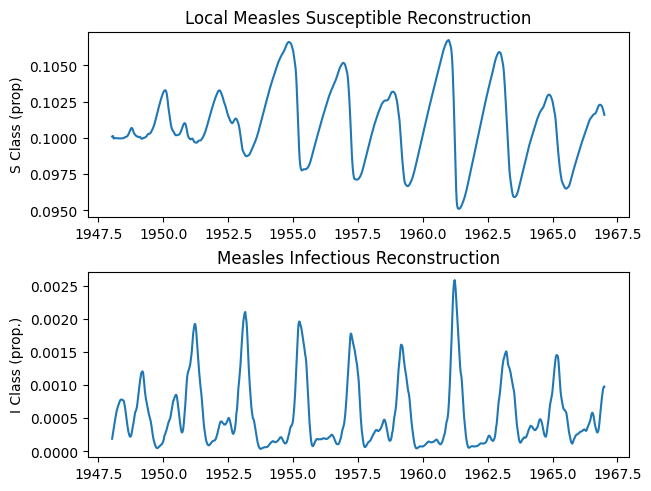

In [ ]:
dataset = load_dataset("measles")
susceptible, infectious, beta = transmission_rate_reconstruction("measles", True)

num_years = int(dataset["week"].values[-1]) - int(dataset["week"].values[0])
transmission_avg, transmission_std = get_calendar_from_transmission(beta, num_years)

fake_beta = np.zeros(len(dataset["week"].values))

beta_0 = (transmission_avg.max() - transmission_avg.min())
beta_1 = (transmission_avg.max() - transmission_avg.min()) / beta_0
phi = 5
dt = float(1./52.)

for i in range(0, len(fake_beta)):
    fake_beta[i] = beta_0 * (1.0 + beta_1 * np.cos(2.0 * np.pi * float(i) * dt - phi))

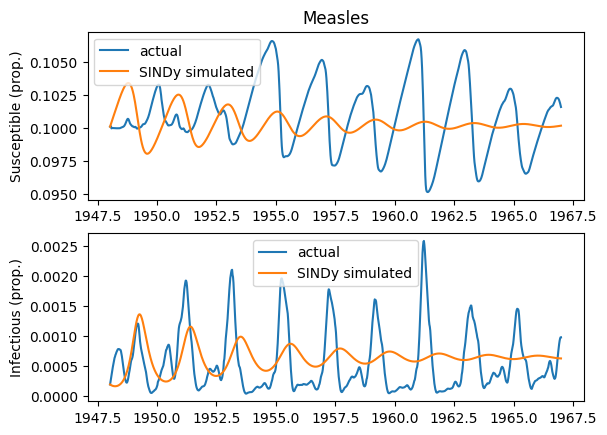

In [327]:
measles_model, init_value = build_sindy(susceptible, infectious, beta, dataset["week"].values, 2, 1e-8)
sim = measles_model.simulate(init_value, t=len(dataset["week"]), u=fake_beta)

fig, ((ax1, ax2)) = plt.subplots(2, 1)

ax1.plot(dataset["week"], susceptible, label="actual")
ax1.plot(dataset["week"], sim[:,0], label="SINDy simulated")
ax1.set_ylabel('Susceptible (prop.)')
ax1.legend()

ax2.plot(dataset["week"], infectious, label="actual")
ax2.plot(dataset["week"], sim[:,1], label="SINDy simulated")
ax2.set_ylabel('Infectious (prop.)')
ax2.legend()

ax1.set_title('Measles')

plt.show()

In [321]:
measles_model.print()

(S)[k+1] = 0.005 1 + 0.901 S[k] + 3.582 I[k] + 0.507 S[k]^2 + -37.335 S[k] I[k] + -81.317 I[k]^2
(I)[k+1] = -0.003 1 + 0.051 S[k] + -0.756 I[k] + -0.240 S[k]^2 + 17.622 S[k] I[k] + 1.042 I[k]^2


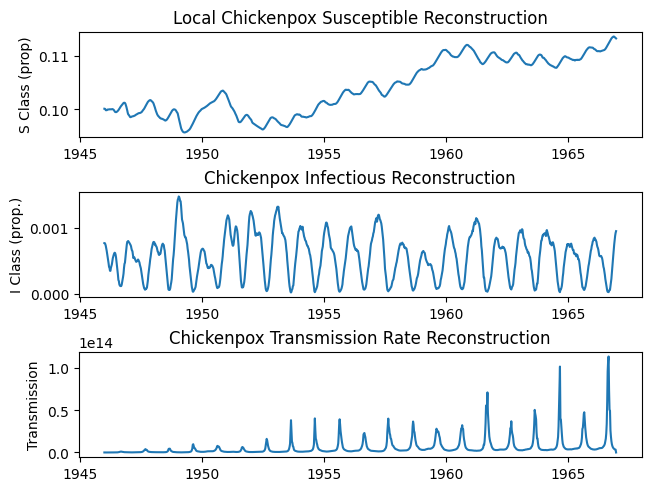

In [269]:
dataset = load_dataset("chickenpox")
susceptible, infectious, beta = transmission_rate_reconstruction("chickenpox", True)

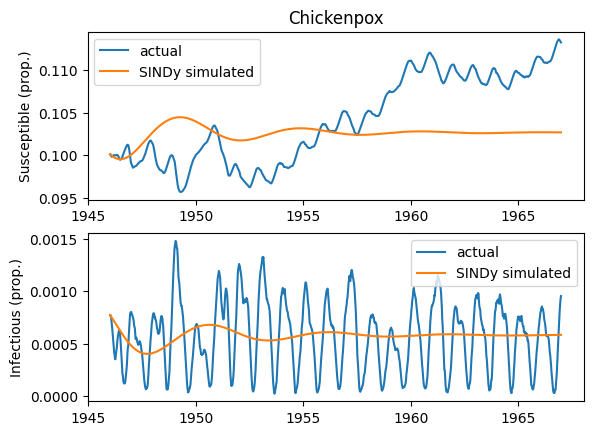

In [271]:
chickenpox_model, init_value = build_sindy(susceptible, infectious, beta, dataset["week"].values, 2, 1e-4)
sim = chickenpox_model.simulate(init_value, t=len(dataset["week"]), u=beta)

fig, ((ax1, ax2)) = plt.subplots(2, 1)

ax1.plot(dataset["week"], susceptible, label="actual")
ax1.plot(dataset["week"], sim[:,0], label="SINDy simulated")
ax1.set_ylabel('Susceptible (prop.)')
ax1.legend()

ax2.plot(dataset["week"], infectious, label="actual")
ax2.plot(dataset["week"], sim[:,1], label="SINDy simulated")
ax2.set_ylabel('Infectious (prop.)')
ax2.legend()

ax1.set_title('Chickenpox')

plt.show()

In [ ]:
chickenpox_model.print()

In [ ]:
dataset = load_dataset("rubella")
susceptible, infectious, beta = transmission_rate_reconstruction("rubella", True)

In [ ]:
rubella_model, init_value = build_sindy(susceptible, infectious, beta, dataset["week"].values, 2, 10e-4)
sim = rubella_model.simulate(init_value, t=len(dataset["week"]), u=beta)

fig, ((ax1, ax2)) = plt.subplots(2, 1)

ax1.plot(dataset["week"], susceptible, label="actual")
ax1.plot(dataset["week"], sim[:,0], label="SINDy simulated")
ax1.set_ylabel('Susceptible (prop.)')
ax1.legend()

ax2.plot(dataset["week"], infectious, label="actual")
ax2.plot(dataset["week"], sim[:,1], label="SINDy simulated")
ax2.set_ylabel('Infectious (prop.)')
ax2.legend()

ax1.set_title('Rubella')

plt.show()

In [ ]:
rubella_model.print()

#### Rubella SINDy Model Construction

In [ ]:
##############################
# Construct SINDy model - NOTE: this does not appear to be very accurate;
# probably need to:
# (1) Denoise data
# (2) Try on other diseases
# (3) Use Power Spectral method
##############################

rubella_si = np.transpose(np.array([rubella_data_nonan["susceptible"].values, rubella_data_nonan["infectious"].values]))

feature_library = ps.PolynomialLibrary(degree=2)
optimizer = ps.STLSQ(threshold=10e-4, normalize_columns=True)

rubella_model = ps.SINDy(
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["S","I","beta"],
    discrete_time=True
)

rubella_model.fit(rubella_si, t=rubella_data_nonan["week"].values, u=beta)
rubella_model.print()

(S)[k+1] = -0.003 1 + 1.072 S[k] + 0.417 I[k] + -0.001 beta[k] + -0.409 S[k]^2 + -5.285 S[k] I[k] + 0.019 S[k] beta[k] + -0.001 beta[k]^2
(I)[k+1] = 0.005 1 + -0.096 S[k] + -1.421 I[k] + 0.433 S[k]^2 + 25.022 S[k] I[k] + 0.001 beta[k]^2


In [135]:
##############################
# Simulate using SINDy model
##############################

init_value = [rubella_data_nonan["susceptible"][0], rubella_data_nonan["infectious"][0]]
sim = rubella_model.simulate(init_value, t=len(rubella_data_nonan["week"]), u=beta)

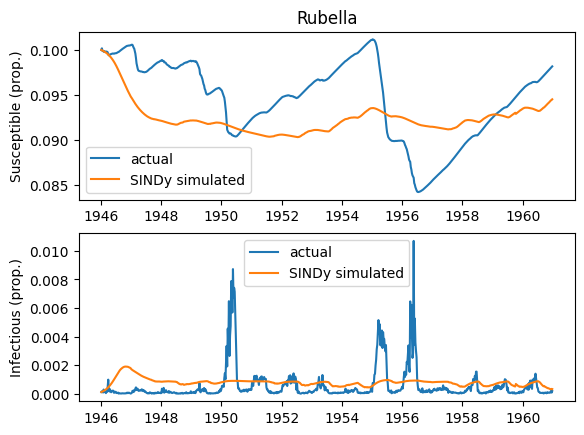

In [136]:
##############################
# Plot data
##############################

fig, ((ax1, ax2)) = plt.subplots(2, 1)

ax1.plot(rubella_data_nonan["week"], rubella_data_nonan["susceptible"], label="actual")
ax1.plot(rubella_data_nonan["week"], sim[:,0], label="SINDy simulated")
ax1.set_ylabel('Susceptible (prop.)')
ax1.legend()

ax2.plot(rubella_data_nonan["week"], rubella_data_nonan["infectious"], label="actual")
ax2.plot(rubella_data_nonan["week"], sim[:,1], label="SINDy simulated")
ax2.set_ylabel('Infectious (prop.)')
ax2.legend()

ax1.set_title('Rubella')

plt.show()